In [14]:
#!pip install matplotlib
# !pip install seaborn
# !pip install datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# 한글 폰트 설정 (한글 깨짐 방지)
plt.rcParams['font.family'] = 'Malgun Gothic'  # Windows
plt.rcParams['axes.unicode_minus'] = False

In [16]:
train = pd.read_csv("train.csv")
print("=== 데이터 기본 정보 ===")
print(f"전체 행 수: {len(train)}")
print(f"전체 열 수: {len(train.columns)}")
print("\n데이터 타입:")
print(train.dtypes)
print("\n기술 통계:")
print(train.describe())


=== 데이터 기본 정보 ===
전체 행 수: 10836
전체 열 수: 9

데이터 타입:
item_id      object
year          int64
month         int64
seq         float64
type          int64
hs4           int64
weight      float64
quantity    float64
value       float64
dtype: object

기술 통계:
               year         month           seq     type           hs4  \
count  10836.000000  10836.000000  10836.000000  10836.0  10836.000000   
mean    2023.331395      6.108435      2.034238      1.0   4821.969546   
std        1.049357      3.392649      0.813380      0.0   2296.892536   
min     2022.000000      1.000000      1.000000      1.0   1210.000000   
25%     2022.000000      3.000000      1.000000      1.0   2833.000000   
50%     2023.000000      6.000000      2.000000      1.0   3824.000000   
75%     2024.000000      9.000000      3.000000      1.0   7202.000000   
max     2025.000000     12.000000      3.000000      1.0   9403.000000   

             weight      quantity         value  
count  1.083600e+04  1.083600e

In [19]:
# 결측치 확인
print("=== 결측치 분석 ===")
missing = train.isnull().sum()
missing_pct = (missing / len(train)) * 100
missing_info = pd.DataFrame({
    '결측치 수': missing,
    '결측치 비율(%)': missing_pct
})
print(missing_info[missing_info['결측치 수'] > 0])

# 0값 분석 
print("=== 0값 분석 ===")
print(f"weight=0인 행: {(train['weight']==0).sum()} ({(train['weight']==0).sum()/len(train)*100:.2f}%)")
print(f"quantity=0인 행: {(train['quantity']==0).sum()} ({(train['quantity']==0).sum()/len(train)*100:.2f}%)")
print(f"value=0인 행: {(train['value']==0).sum()} ({(train['value']==0).sum()/len(train)*100:.2f}%)")

# 모두 0인 행 확인
all_zero = train[(train['weight']==0) & (train['quantity']==0) & (train['value']==0)]
print(f"\nweight, quantity, value 모두 0인 행: {len(all_zero)}")

=== 결측치 분석 ===
Empty DataFrame
Columns: [결측치 수, 결측치 비율(%)]
Index: []
=== 0값 분석 ===
weight=0인 행: 935 (8.63%)
quantity=0인 행: 8919 (82.31%)
value=0인 행: 636 (5.87%)

weight, quantity, value 모두 0인 행: 635


In [21]:
# 고유값 확인
print("=== 고유값 분석 ===")
print(f"총 품목 수(item_id): {train['item_id'].nunique()}")
print(f"연도 범위: {train['year'].min()} ~ {train['year'].max()}")
print(f"월 범위: {train['month'].min()} ~ {train['month'].max()}")
print(f"고유 hs4 코드 수: {train['hs4'].nunique()}")
print(f"고유 type 값: {train['type'].unique()}")
print(f"고유 seq 값: {train['seq'].unique()}")

# 품목별 데이터 건수
item_counts = train['item_id'].value_counts()
print(f"품목별 평균 거래 건수: {item_counts.mean():.2f}")
print(f"품목별 최소 거래 건수: {item_counts.min()}")
print(f"품목별 최대 거래 건수: {item_counts.max()}")

# 시간 범위 확인
train['date'] = pd.to_datetime(train['year'].astype(str) + '-' + train['month'].astype(str) + '-01')
print(f"데이터 기간: {train['date'].min()} ~ {train['date'].max()}")
print(f"총 개월 수: {train['date'].nunique()}")


=== 고유값 분석 ===
총 품목 수(item_id): 100
연도 범위: 2022 ~ 2025
월 범위: 1 ~ 12
고유 hs4 코드 수: 71
고유 type 값: [1]
고유 seq 값: [1. 2. 3.]
품목별 평균 거래 건수: 108.36
품목별 최소 거래 건수: 2
품목별 최대 거래 건수: 129
데이터 기간: 2022-01-01 00:00:00 ~ 2025-07-01 00:00:00
총 개월 수: 43


In [23]:
# 월별 품목별 합계 계산 (seq가 여러 건일 수 있으므로 집계)
monthly_data = train.groupby(['item_id', 'year', 'month']).agg({
    'weight': 'sum',
    'quantity': 'sum',
    'value': 'sum',
    'hs4': 'first'  # hs4는 품목별로 동일할 것으로 예상
}).reset_index()

monthly_data['date'] = pd.to_datetime(
    monthly_data['year'].astype(str) + '-' + monthly_data['month'].astype(str) + '-01'
)

print("=== 월별 집계 데이터 ===")
print(f"총 행 수: {len(monthly_data)}")
print(f"예상 행 수 (100개 품목 × 43개월): {100 * 43}")
print("집계 데이터 샘플:")
print(monthly_data.head())

# 결측 월 확인
items_months = monthly_data.groupby('item_id')['date'].count()
print(f"품목별 데이터 개월 수:")
print(items_months.describe())


=== 월별 집계 데이터 ===
총 행 수: 3776
예상 행 수 (100개 품목 × 43개월): 4300
집계 데이터 샘플:
    item_id  year  month    weight  quantity    value   hs4       date
0  AANGBULD  2022      1   17625.0       0.0  14276.0  4810 2022-01-01
1  AANGBULD  2022      2   67983.0       0.0  52347.0  4810 2022-02-01
2  AANGBULD  2022      3   69544.0       0.0  53549.0  4810 2022-03-01
3  AANGBULD  2022      5   34173.0       0.0  26997.0  4810 2022-05-01
4  AANGBULD  2022      6  103666.0       0.0  84489.0  4810 2022-06-01
품목별 데이터 개월 수:
count    100.000000
mean      37.760000
std       11.124747
min        1.000000
25%       40.000000
50%       43.000000
75%       43.000000
max       43.000000
Name: date, dtype: float64


=== 품목별 무역량(value) 통계 ===
            count          mean        median           std           min  \
count  100.000000  1.000000e+02  1.000000e+02  9.900000e+01  1.000000e+02   
mean    37.760000  4.491328e+06  4.031019e+06  1.861481e+06  2.139053e+06   
std     11.124747  1.331868e+07  1.269975e+07  4.549435e+06  9.747441e+06   
min      1.000000  9.267000e+01  4.500000e+01  9.360000e+01  1.000000e+00   
25%     40.000000  5.993582e+04  3.410550e+04  7.003805e+04  3.252500e+02   
50%     43.000000  3.345766e+05  2.713225e+05  2.783281e+05  2.912800e+04   
75%     43.000000  3.283875e+06  2.594343e+06  1.146459e+06  8.238285e+05   
max     43.000000  1.086511e+08  1.086249e+08  3.273012e+07  9.264894e+07   

                max         cv  
count  1.000000e+02  99.000000  
mean   9.801731e+06   0.849899  
std    2.380818e+07   0.632851  
min    2.000000e+02   0.070000  
25%    3.188735e+05   0.465000  
50%    1.248853e+06   0.680000  
75%    6.641034e+06   1.035000  
max    1.462168e

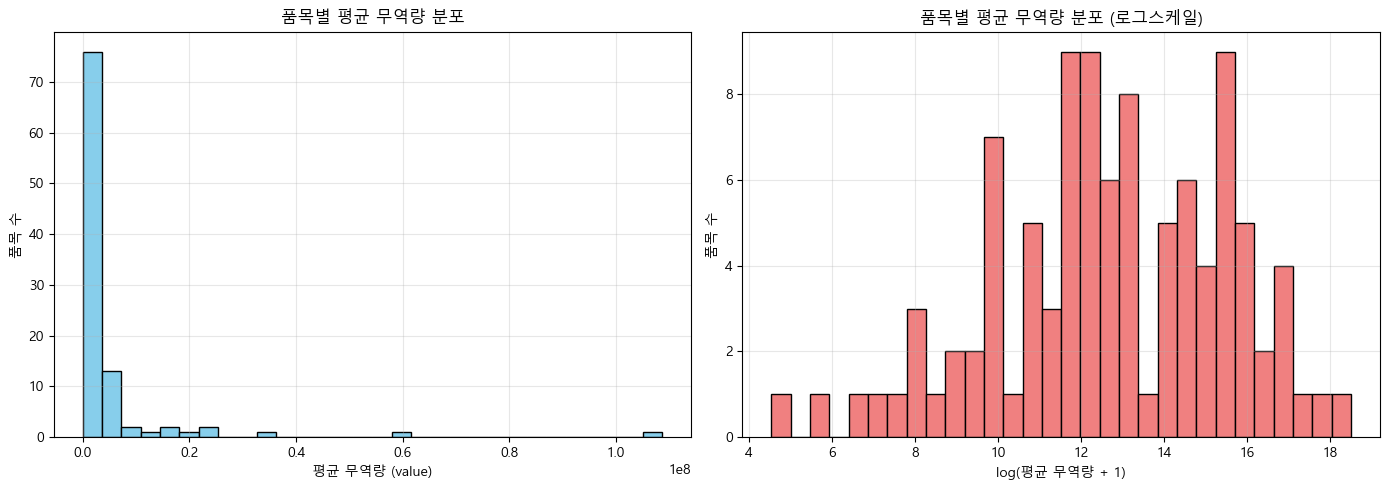

그래프 저장: item_value_distribution.png


In [26]:
# 품목별 무역량(value) 통계
item_stats = monthly_data.groupby('item_id')['value'].agg([
    'count', 'mean', 'median', 'std', 'min', 'max'
]).round(2)
item_stats['cv'] = (item_stats['std'] / item_stats['mean']).round(2)  # 변동계수

print("=== 품목별 무역량(value) 통계 ===")
print(item_stats.describe())
print("상위 5개 품목 (평균 무역량 기준):")
print(item_stats.nlargest(5, 'mean'))
print("하위 5개 품목 (평균 무역량 기준):")
print(item_stats.nsmallest(5, 'mean'))

# 무역량 분포 시각화
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 품목별 평균 무역량 분포 (색상 지정)
axes[0].hist(item_stats['mean'], bins=30, edgecolor='black', color='skyblue')
axes[0].set_xlabel('평균 무역량 (value)')
axes[0].set_ylabel('품목 수')
axes[0].set_title('품목별 평균 무역량 분포')
axes[0].grid(True, alpha=0.3)

# 로그 스케일로 확인 (색상 지정)
axes[1].hist(np.log1p(item_stats['mean']), bins=30, edgecolor='black', color='lightcoral')
axes[1].set_xlabel('log(평균 무역량 + 1)')
axes[1].set_ylabel('품목 수')
axes[1].set_title('품목별 평균 무역량 분포 (로그스케일)')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('item_value_distribution.png', dpi=100, bbox_inches='tight')  # color 파라미터 제거
plt.show()

print("그래프 저장: item_value_distribution.png")

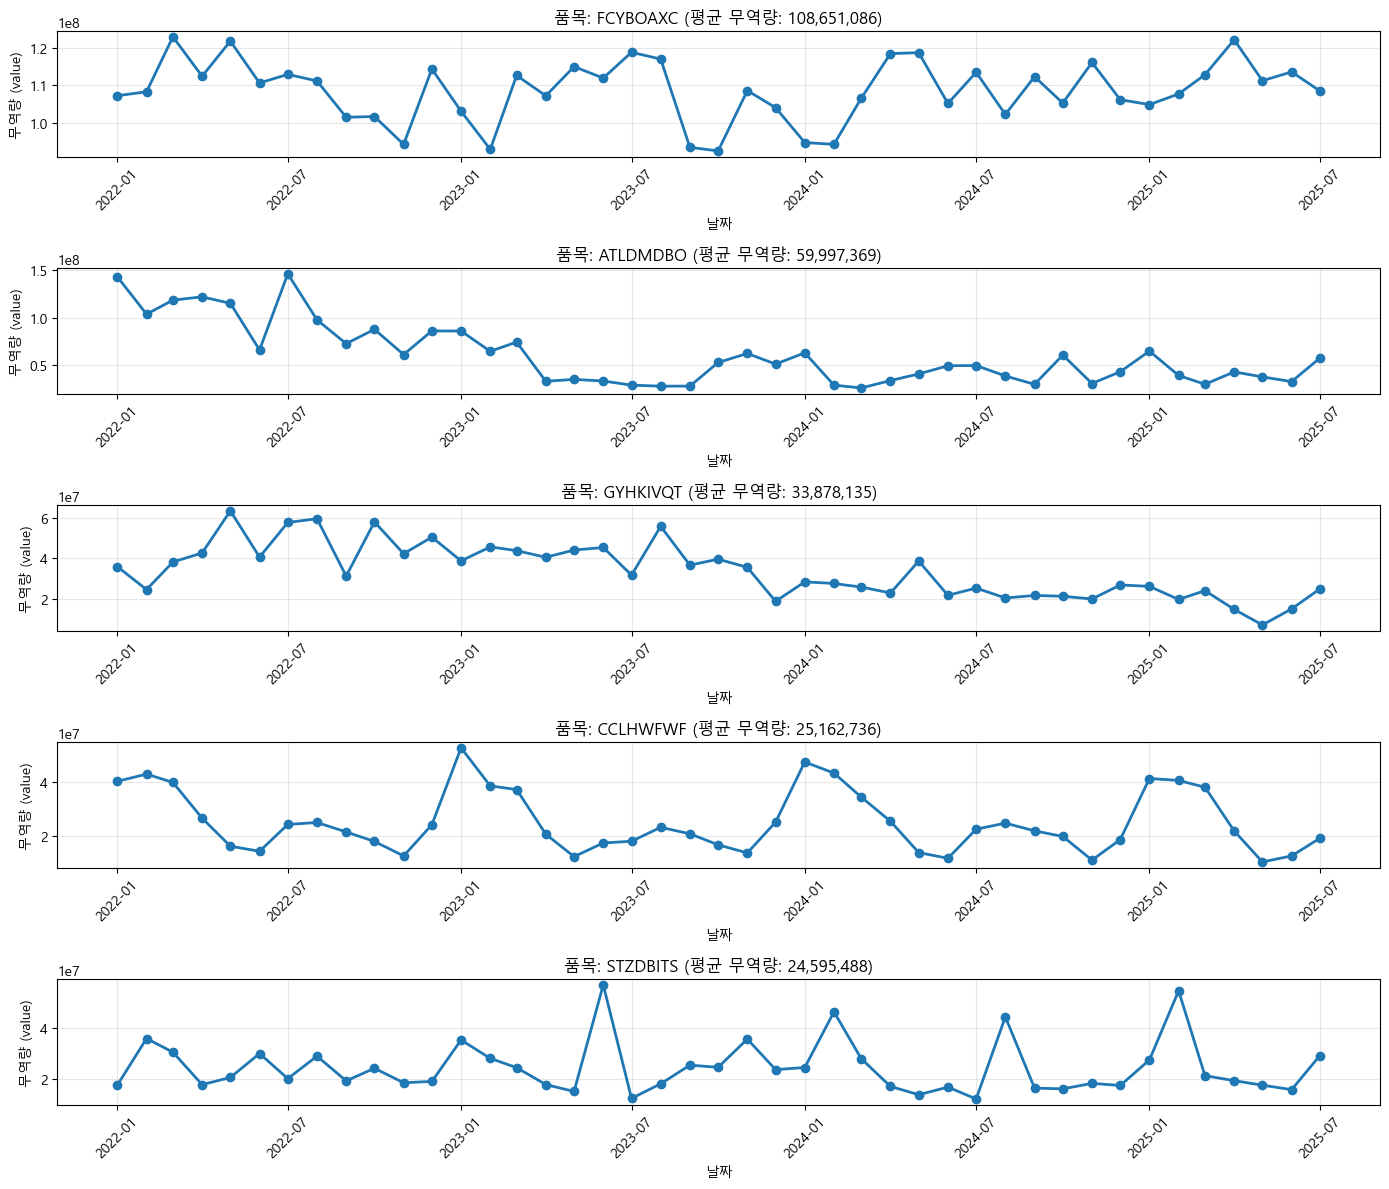

그래프 저장: top5_items_timeseries.png


In [27]:
# 평균 무역량 기준 상위 5개 품목 시각화
top_items = item_stats.nlargest(5, 'mean').index.tolist()

fig, axes = plt.subplots(5, 1, figsize=(14, 12))

for idx, item in enumerate(top_items):
    item_data = monthly_data[monthly_data['item_id'] == item].sort_values('date')
    
    axes[idx].plot(item_data['date'], item_data['value'], marker='o', linewidth=2)
    axes[idx].set_title(f'품목: {item} (평균 무역량: {item_stats.loc[item, "mean"]:,.0f})')
    axes[idx].set_xlabel('날짜')
    axes[idx].set_ylabel('무역량 (value)')
    axes[idx].grid(True, alpha=0.3)
    axes[idx].tick_params(axis='x', rotation=45)

plt.tight_layout()
#plt.savefig('top5_items_timeseries.png', dpi=100, bbox_inches='tight')
plt.show()

print("그래프 저장: top5_items_timeseries.png")
